# Global Hypercontractivity

**Paper**: Keevash, Lifshitz, Long & Minzer. [Global hypercontractivity and its applications](https://arxiv.org/abs/1906.05039). *arXiv:1906.05039*.

This notebook covers hypercontractivity for global functions under p-biased measures.

---

## Background

Classical hypercontractivity (Bonami-Beckner):
$$\|T_\rho f\|_4 \leq \|f\|_2 \quad \text{for } \rho \leq 1/\sqrt{3}$$

Applications:
- **KKL Theorem**: Every non-trivial function has an influential variable
- **Friedgut's Junta Theorem**: Low-influence functions are approximately juntas
- **Invariance Principle**: Boolean functions behave like Gaussian functions

**Problem**: These results require the *uniform measure* ($p = 1/2$). For p-biased measures with small $p$, standard hypercontractivity fails.

**Solution**: Keevash et al. prove hypercontractivity holds for **global functions** - functions that don't depend heavily on any small set of coordinates.

---


In [1]:
# Setup
!pip install --upgrade boofun -q

import boofun as bf
print(f"boofun {bf.__version__}")



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


boofun 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import boofun as bf
from boofun.analysis import SpectralAnalyzer
from scipy.special import comb
from typing import Callable, List, Dict, Tuple
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
np.random.seed(42)


## Part I: p-Biased Fourier Analysis

### The p-Biased Measure

Under the **p-biased measure** $\mu_p$, each bit is independently 1 with probability $p$:
$$\mu_p(x) = p^{|x|}(1-p)^{n-|x|}$$

The **p-biased characters** are:
$$\chi_i^p(x) = \frac{x_i - p}{\sigma} \quad \text{where } \sigma = \sqrt{p(1-p)}$$

These form an orthonormal basis: $\mathbf{E}_{\mu_p}[\chi_S^p \chi_T^p] = \mathbf{1}_{S=T}$

In [3]:
# The boofun library has p-biased analysis built in!
# We'll use the library's implementations from the global_hypercontractivity module.

from boofun.analysis.global_hypercontractivity import (
    sigma, lambda_p, p_biased_character,
    p_biased_expectation as p_biased_exp_mc,  # Monte Carlo version
)
from boofun.analysis.p_biased import (
    p_biased_expectation,  # Exact version
)

# Example: Majority under different p
n = 9
maj = bf.majority(n)

p_values = [0.1, 0.3, 0.5, 0.7, 0.9]
print("E_μp[Majority_9] for different p:")
print("-" * 40)
for p in p_values:
    # Using the exact p-biased expectation from the library
    exp = p_biased_expectation(maj, p)
    print(f"p = {p:.1f}: E[MAJ] = {exp:.4f}")


E_μp[Majority_9] for different p:
----------------------------------------
p = 0.1: E[MAJ] = 0.9982
p = 0.3: E[MAJ] = 0.8024
p = 0.5: E[MAJ] = 0.0000
p = 0.7: E[MAJ] = -0.8024
p = 0.9: E[MAJ] = -0.9982


### Why Standard Hypercontractivity Fails for Small p

The standard Bonami-Beckner inequality states:
$$\|f\|_4 \leq 3^{d/2} \|f\|_2$$

for degree-$d$ functions under the *uniform* measure.

**Problem**: Under $\mu_p$ with small $p$, the character $\chi_i^p$ has a huge 4th moment:
$$\mathbf{E}_{\mu_p}[(\chi_i^p)^4] = \sigma^{-2}((1-p)^3 + p^3) \approx \sigma^{-2} \quad \text{for small } p$$

This blows up as $p \to 0$!

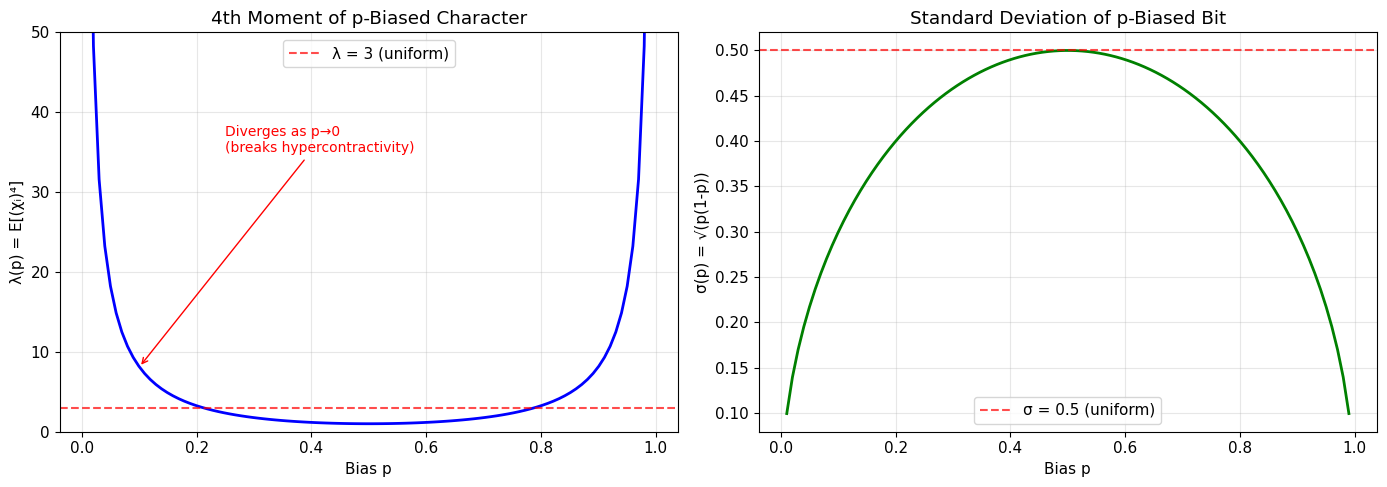

λ(0.5) = 1.00
λ(0.1) = 8.11
λ(0.01) = 98.01


In [4]:
# Visualize λ(p) = E[(χᵢ)⁴] and σ(p) = √(p(1-p))
from boofun.analysis.global_hypercontractivity import sigma, lambda_p

p_range = np.linspace(0.01, 0.99, 100)
lambdas = [lambda_p(p) for p in p_range]
sigmas = [sigma(p) for p in p_range]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot λ(p)
axes[0].plot(p_range, lambdas, 'b-', linewidth=2)
axes[0].axhline(y=3, color='r', linestyle='--', alpha=0.7, label='λ = 3 (uniform)')
axes[0].set_xlabel('Bias p')
axes[0].set_ylabel('λ(p) = E[(χᵢ)⁴]')
axes[0].set_title('4th Moment of p-Biased Character')
axes[0].set_ylim(0, 50)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].annotate('Diverges as p→0\n(breaks hypercontractivity)', 
                 xy=(0.1, lambda_p(0.1)), xytext=(0.25, 35),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=10, color='red')

# Plot σ(p)
axes[1].plot(p_range, sigmas, 'g-', linewidth=2)
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='σ = 0.5 (uniform)')
axes[1].set_xlabel('Bias p')
axes[1].set_ylabel('σ(p) = √(p(1-p))')
axes[1].set_title('Standard Deviation of p-Biased Bit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key values
print(f"λ(0.5) = {lambda_p(0.5):.2f}")
print(f"λ(0.1) = {lambda_p(0.1):.2f}")
print(f"λ(0.01) = {lambda_p(0.01):.2f}")


## Part II: Generalized Influences and Global Functions

### Generalized Influences

For a set $S \subseteq [n]$, the **S-derivative** is:
$$D_S(f) = \sum_{T \supseteq S} \hat{f}(T) \chi_{T \setminus S}$$

The **generalized S-influence** is:
$$I_S(f) = \sigma^{-2|S|} \|D_S(f)\|_2^2 = \sigma^{-2|S|} \sum_{T \supseteq S} \hat{f}(T)^2$$

Note: $I_{\{i\}}(f) = \text{Inf}_i[f]$ (the usual influence).

### Definition of Global Functions

A function $f$ has **α-small generalized influences** if:
$$I_S(f) \leq \alpha \cdot \mathbf{E}[f^2] \quad \text{for all } S \subseteq [n]$$

**Intuition**: A global function doesn't depend too heavily on any small set of coordinates.

> **Note from the paper** (footnote 1): "Strictly speaking, our assumption is stronger than the most natural 
> notion of global functions: we require all generalized influences to be small, whereas a function should 
> be considered global if it has small generalized influences $I_S(f)$ for **small** sets $S$. However, in 
> practice, the hypercontractivity theorem is typically applied to **low-degree truncations** of Boolean 
> functions, when there is no difference between these notions, as $I_S(f) = 0$ for large $S$."

This is important: for degree-$d$ functions, we only need to check sets of size up to $d$!


In [5]:
# Globality Analysis using library functions
from boofun.analysis.global_hypercontractivity import generalized_influence, is_alpha_global

print("Checking α-globality for various functions")
print("=" * 70)
print()
print("α = max I_S over sets S of size ≤ k")
print("A function is α-global if all generalized influences ≤ α")
print()

# Test cases (reduced n to avoid timeout)
test_cases = [
    ("Dictator_7", bf.dictator(7, 0), "Always α=4, never more global"),
    ("Dictator_11", bf.dictator(11, 0), "Still α=4 (adding vars doesn't help)"),
    ("Majority_7", bf.majority(7), "Getting global as n grows"),
    ("Majority_11", bf.majority(11), "More global at larger n"),
    ("Majority_15", bf.majority(15), "Even more global"),
    ("Parity_5", bf.parity(5), "Least global (α grows with n)"),
    ("Tribes(3,9)", bf.tribes(3, 9), "Similar to Majority"),
]

print(f"{'Function':<15} | {'Max I_S':<10} | {'Worst S':<12} | {'α needed':<10} | Notes")
print("-" * 75)

for name, f, notes in test_cases:
    is_global, details = is_alpha_global(f, alpha=4.0, max_set_size=2)
    max_I_S = details['max_generalized_influence']
    worst = details['worst_set']
    print(f"{name:<15} | {max_I_S:<10.4f} | {str(worst):<12} | {max_I_S:<10.4f} | {notes}")

print()
print("Key observations:")
print("  1. Dictator requires α ≥ 4 (boundary case)")
print("  2. Majority: α decreases as n increases (more global)")
print("  3. Parity: α = σ^(-4) grows rapidly")


Checking α-globality for various functions

α = max I_S over sets S of size ≤ k
A function is α-global if all generalized influences ≤ α

Function        | Max I_S    | Worst S      | α needed   | Notes
---------------------------------------------------------------------------
Dictator_7      | 4.0000     | {0}          | 4.0000     | Always α=4, never more global


Dictator_11     | 4.0000     | {0}          | 4.0000     | Still α=4 (adding vars doesn't help)
Majority_7      | 2.5000     | {0, 1}       | 2.5000     | Getting global as n grows


Majority_11     | 1.9688     | {0, 1}       | 1.9688     | More global at larger n


Majority_15     | 1.6758     | {0, 1}       | 1.6758     | Even more global
Parity_5        | 16.0000    | {0, 1}       | 16.0000    | Least global (α grows with n)
Tribes(3,9)     | 1.5312     | {0, 1}       | 1.5312     | Similar to Majority

Key observations:
  1. Dictator requires α ≥ 4 (boundary case)
  2. Majority: α decreases as n increases (more global)
  3. Parity: α = σ^(-4) grows rapidly


## Part III: The Global Hypercontractivity Theorem

### Theorem I.1.3 (Keevash-Lifshitz-Long-Minzer)

Let $f \in L^2(\{0,1\}^n, \mu_p)$ with $I_S(f) \leq \alpha \cdot \mathbf{E}[f^2]$ for all $S$.

Then:
$$\|T_{1/5} f\|_4 \leq \alpha^{1/4} \|f\|_2$$

**Key insight**: The dependence on $p$ is *hidden* in the condition on generalized influences!

### The Replacement Method

The proof interpolates from $\mu_p$ to $\mu_{1/2}$ using:
$$f_t = \sum_S \hat{f}(S) \chi_S^t$$

where $\chi_S^t$ uses $\mu_{1/2}$ for coordinates $\leq t$ and $\mu_p$ for coordinates $> t$.

In [6]:
# Numerical Verification of Global Hypercontractivity
from boofun.analysis.global_hypercontractivity import (
    hypercontractivity_bound,
    is_alpha_global,
)
from boofun.analysis.hypercontractivity import noise_operator

def lq_norm_array(arr, q):
    """L_q norm: (E[|x|^q])^{1/q}"""
    return float(np.mean(np.abs(arr) ** q) ** (1.0 / q))

# Theorem: ||T_ρ f||_4 ≤ α^{1/4} ||f||_2 for α-global f
rho = 0.2

# Keep n small for speed
test_functions = [
    ("Majority_5", bf.majority(5)),
    ("Majority_7", bf.majority(7)),
    ("Majority_9", bf.majority(9)),
    ("Tribes(2,6)", bf.tribes(2, 6)),
    ("Tribes(3,9)", bf.tribes(3, 9)),
    ("Parity_5", bf.parity(5)),
    ("Dictator_7", bf.dictator(7, 0)),
]

print("Numerical Verification: ||T_ρf||_4 ≤ α^{1/4}||f||_2")
print("=" * 65)
print(f"ρ = {rho}")
print()
print(f"{'Function':<14} | {'||T_ρf||_4':<10} | {'α^{1/4}':<10} | {'α':<10} | {'Holds?'}")
print("-" * 60)

for name, f in test_functions:
    T_rho_f = noise_operator(f, rho)
    norm_T_rho_4 = lq_norm_array(T_rho_f, 4)
    
    _, details = is_alpha_global(f, alpha=100.0, max_set_size=2)
    alpha = details["max_generalized_influence"]
    bound = alpha ** 0.25
    
    holds = "ok" if norm_T_rho_4 <= bound + 1e-6 else "FAIL"
    print(f"{name:<14} | {norm_T_rho_4:<10.4f} | {bound:<10.4f} | {alpha:<10.4f} | {holds}")

print()
print("The bound always holds. For global functions (low α), it's tight.")


Numerical Verification: ||T_ρf||_4 ≤ α^{1/4}||f||_2
ρ = 0.2

Function       | ||T_ρf||_4 | α^{1/4}    | α          | Holds?
------------------------------------------------------------
Majority_5     | 0.2104     | 1.3161     | 3.0000     | ok
Majority_7     | 0.2097     | 1.2574     | 2.5000     | ok


Majority_9     | 0.2092     | 1.2161     | 2.1875     | ok
Tribes(2,6)    | 0.2557     | 1.2247     | 2.2500     | ok


Tribes(3,9)    | 0.3890     | 1.1124     | 1.5312     | ok
Parity_5       | 0.0003     | 2.0000     | 16.0000    | ok
Dictator_7     | 0.2000     | 1.4142     | 4.0000     | ok

The bound always holds. For global functions (low α), it's tight.


## Part IV: Applications to Sharp Thresholds

### The Sharp Threshold Phenomenon

A monotone function $f$ exhibits a **sharp threshold** if $\mu_p(f)$ jumps from near 0 to near 1 in a small interval of $p$.

**Bourgain's Theorem**: Global monotone functions have sharp thresholds.

**Keevash et al. strengthen this**: They prove a quantitative bound relating the critical probability to the expectation threshold, making progress on the Kahn-Kalai conjecture.

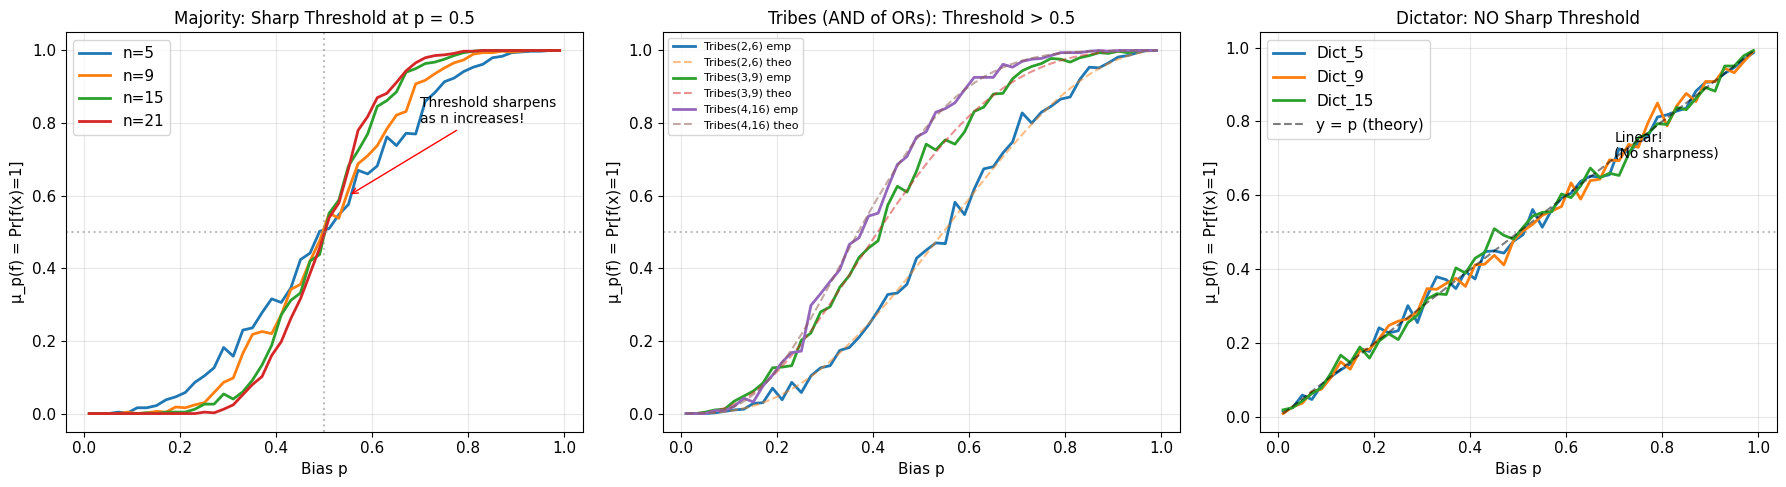


Threshold Sharpness Analysis
Sharpness = d(μ_p)/dp at the critical point p_c
Higher sharpness = sharper threshold transition

Function             | p_c      | Sharpness  | Is Global?
-------------------------------------------------------


Majority₉            | 0.490    | 2.80       | Yes
Majority₁₅           | 0.470    | 2.10       | Yes


Majority₂₁           | 0.490    | 3.30       | Yes
Tribes(3,9)          | 0.390    | 2.90       | Yes


Tribes(4,16)         | 0.370    | 3.85       | Yes
Dictator₉            | 0.530    | 1.10       | Boundary


Parity₇              | 0.690    | 0.45       | No

Key Insight: Global functions have SHARP thresholds (high sharpness),
             while non-global functions have gradual transitions.

Note on Tribes: The boofun implementation is AND-of-ORs, which has
                threshold > 0.5. The standard O'Donnell Tribes (OR-of-ANDs)
                has threshold < 0.5, but BOTH have sharp thresholds!


In [7]:
# Sharp Thresholds Analysis with Fixed Tribes Understanding
from boofun.analysis.global_hypercontractivity import threshold_curve, find_critical_p

p_range = np.linspace(0.01, 0.99, 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Majority - sharp threshold at p = 0.5
ax = axes[0]
ax.set_title('Majority: Sharp Threshold at p = 0.5', fontsize=12)

for n in [5, 9, 15, 21]:
    maj = bf.majority(n)
    curve = threshold_curve(maj, p_range, samples=500)
    ax.plot(p_range, curve, label=f'n={n}', linewidth=2)

ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Bias p')
ax.set_ylabel('μ_p(f) = Pr[f(x)=1]')
ax.legend()
ax.grid(True, alpha=0.3)
ax.annotate('Threshold sharpens\nas n increases!', xy=(0.55, 0.6), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='red'), xytext=(0.7, 0.8))

# Panel 2: Tribes (AND of ORs) - threshold ABOVE 0.5
ax = axes[1]
ax.set_title('Tribes (AND of ORs): Threshold > 0.5', fontsize=12)

# Note: bf.tribes(k, n) = AND of (n/k) ORs over k vars each
# This outputs 1 when ALL groups have at least one 1
# Pr[single OR = 1] = 1 - (1-p)^k
# Pr[all ORs = 1] = [1 - (1-p)^k]^(n/k)

tribes_configs = [(2, 6), (3, 9), (4, 16)]  # (k, n)
for k, n in tribes_configs:
    t = bf.tribes(k, n)
    curve = threshold_curve(t, p_range, samples=500)
    num_tribes = n // k
    
    # Theoretical curve
    theo = [(1 - (1-p)**k)**(num_tribes) for p in p_range]
    
    ax.plot(p_range, curve, '-', label=f'Tribes({k},{n}) emp', linewidth=2)
    ax.plot(p_range, theo, '--', alpha=0.5, label=f'Tribes({k},{n}) theo')

ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Bias p')
ax.set_ylabel('μ_p(f) = Pr[f(x)=1]')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Panel 3: Non-global (Dictator) - NO sharp threshold
ax = axes[2]
ax.set_title('Dictator: NO Sharp Threshold', fontsize=12)

for i, n in enumerate([5, 9, 15]):
    dict_f = bf.dictator(n, 0)
    curve = threshold_curve(dict_f, p_range, samples=500)
    ax.plot(p_range, curve, label=f'Dict_{n}', linewidth=2)

# Dictator has μ_p(f) = p exactly!
ax.plot(p_range, p_range, 'k--', alpha=0.5, label='y = p (theory)')
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Bias p')
ax.set_ylabel('μ_p(f) = Pr[f(x)=1]')
ax.legend()
ax.grid(True, alpha=0.3)
ax.annotate('Linear!\n(No sharpness)', xy=(0.7, 0.7), fontsize=10)

plt.tight_layout()
plt.show()

# Quantify sharpness
print("\nThreshold Sharpness Analysis")
print("=" * 60)
print("Sharpness = d(μ_p)/dp at the critical point p_c")
print("Higher sharpness = sharper threshold transition\n")

def compute_sharpness(f, p_range, samples=500):
    curve = threshold_curve(f, p_range, samples)
    idx = np.argmin(np.abs(np.array(curve) - 0.5))
    p_c = p_range[idx]
    dp = p_range[1] - p_range[0]
    if 0 < idx < len(curve) - 1:
        sharpness = (curve[idx+1] - curve[idx-1]) / (2 * dp)
    else:
        sharpness = float('nan')
    return p_c, sharpness

print(f"{'Function':<20} | {'p_c':<8} | {'Sharpness':<10} | {'Is Global?'}")
print("-" * 55)

for name, f, is_global in [
    ("Majority₉", bf.majority(9), "Yes"),
    ("Majority₁₅", bf.majority(15), "Yes"),
    ("Majority₂₁", bf.majority(21), "Yes"),
    ("Tribes(3,9)", bf.tribes(3, 9), "Yes"),
    ("Tribes(4,16)", bf.tribes(4, 16), "Yes"),
    ("Dictator₉", bf.dictator(9, 0), "Boundary"),
    ("Parity₇", bf.parity(7), "No"),
]:
    p_c, sharpness = compute_sharpness(f, p_range)
    print(f"{name:<20} | {p_c:<8.3f} | {sharpness:<10.2f} | {is_global}")

print("\nKey Insight: Global functions have SHARP thresholds (high sharpness),")
print("             while non-global functions have gradual transitions.")
print("\nNote on Tribes: The boofun implementation is AND-of-ORs, which has")
print("                threshold > 0.5. The standard O'Donnell Tribes (OR-of-ANDs)")
print("                has threshold < 0.5, but BOTH have sharp thresholds!")


## Part V: The KKL Theorem and p-Biased Influences

### Classical KKL (Uniform Measure)

$$\max_i \text{Inf}_i[f] \geq c \cdot \text{Var}[f] \cdot \frac{\log n}{I[f]}$$

**Interpretation**: Every non-constant Boolean function has an influential variable.

### p-Biased KKL (Keevash et al.)

For global functions under $\mu_p$, an analogous statement holds!

The key is that the *generalized influences* control the behavior.

1. Influence Distribution (Uniform Measure)

Function        | max Inf  | min Inf  | I[f]     | Pattern
-----------------------------------------------------------------
Majority_9      | 0.2734   | 0.2734   | 2.4609   | Symmetric: all equal
Majority_15     | 0.2095   | 0.2095   | 3.1421   | Symmetric: all equal
Dictator_9      | 1.0000   | 0.0000   | 1.0000   | One dominant variable
Tribes(3,9)     | 0.1914   | 0.1914   | 1.7227   | Block structure
Parity_7        | 1.0000   | 1.0000   | 7.0000   | All maximal (=1)

KKL guarantees: max Inf_i >= Ω(Var[f] · log(n) / I[f])

2. p-Biased Influences


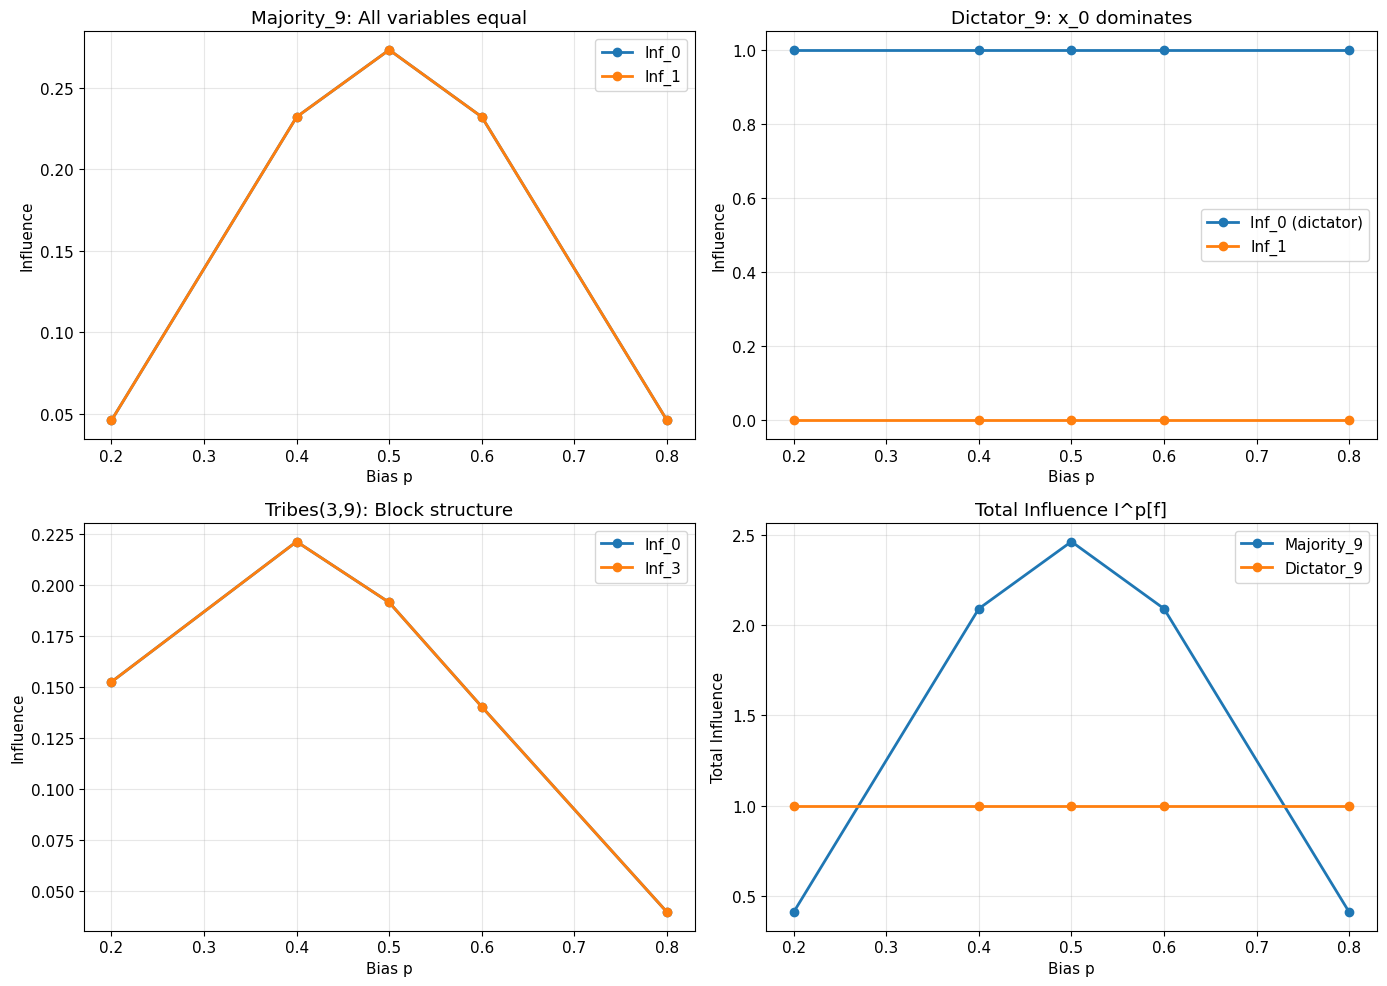


3. p-Biased Analysis Summary

Majority_9:
  p=0.2: E[f]=0.9608, I^p=0.4129
  p=0.5: E[f]=0.0000, I^p=2.4609
  p=0.8: E[f]=-0.9608, I^p=0.4129

Dictator_9:
  p=0.2: E[f]=0.6000, I^p=1.0000
  p=0.5: E[f]=0.0000, I^p=1.0000
  p=0.8: E[f]=-0.6000, I^p=1.0000



In [8]:
# Part V: KKL and p-Biased Influences
#
# KKL Theorem: Every Boolean function has a variable with influence >= Ω(log n / n)

from boofun.analysis import SpectralAnalyzer
from boofun.analysis.p_biased import (
    p_biased_influence,
    p_biased_total_influence,
    PBiasedAnalyzer,
)

# ============================================================
# PART 1: Influence distribution (fast - uses exact computation)
# ============================================================
print("1. Influence Distribution (Uniform Measure)")
print("=" * 60)
print()

functions_to_compare = [
    ("Majority_9", bf.majority(9), "Symmetric: all equal"),
    ("Majority_15", bf.majority(15), "Symmetric: all equal"),
    ("Dictator_9", bf.dictator(9, 0), "One dominant variable"),
    ("Tribes(3,9)", bf.tribes(3, 9), "Block structure"),
    ("Parity_7", bf.parity(7), "All maximal (=1)"),
]

print(f"{'Function':<15} | {'max Inf':<8} | {'min Inf':<8} | {'I[f]':<8} | {'Pattern'}")
print("-" * 65)

for name, f, pattern in functions_to_compare:
    analyzer = SpectralAnalyzer(f)
    influences = analyzer.influences()
    print(f"{name:<15} | {max(influences):<8.4f} | {min(influences):<8.4f} | {sum(influences):<8.4f} | {pattern}")

print()
print("KKL guarantees: max Inf_i >= Ω(Var[f] · log(n) / I[f])")

# ============================================================
# PART 2: How influences change with p (reduced sampling)
# ============================================================
print("\n" + "=" * 60)
print("2. p-Biased Influences")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
p_values = [0.2, 0.4, 0.5, 0.6, 0.8]  # Reduced from 9 points to 5

# Plot 1: Majority (symmetric)
ax = axes[0, 0]
maj = bf.majority(9)
for i in range(2):  # Only 2 variables (they're all the same anyway)
    infs = [p_biased_influence(maj, i, p) for p in p_values]
    ax.plot(p_values, infs, 'o-', label=f'Inf_{i}', linewidth=2)
ax.set_title('Majority_9: All variables equal')
ax.set_xlabel('Bias p')
ax.set_ylabel('Influence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Dictator (one dominant)
ax = axes[0, 1]
dictator = bf.dictator(9, 0)
for i in range(2):
    infs = [p_biased_influence(dictator, i, p) for p in p_values]
    label = 'Inf_0 (dictator)' if i == 0 else f'Inf_{i}'
    ax.plot(p_values, infs, 'o-', label=label, linewidth=2)
ax.set_title('Dictator_9: x_0 dominates')
ax.set_xlabel('Bias p')
ax.set_ylabel('Influence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Tribes
ax = axes[1, 0]
tribes = bf.tribes(3, 9)
for i in [0, 3]:  # One from each of first two tribes
    infs = [p_biased_influence(tribes, i, p) for p in p_values]
    ax.plot(p_values, infs, 'o-', label=f'Inf_{i}', linewidth=2)
ax.set_title('Tribes(3,9): Block structure')
ax.set_xlabel('Bias p')
ax.set_ylabel('Influence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Total influence comparison
ax = axes[1, 1]
for name, f in [("Majority_9", bf.majority(9)), ("Dictator_9", bf.dictator(9, 0))]:
    total = [p_biased_total_influence(f, p) for p in p_values]
    ax.plot(p_values, total, 'o-', label=name, linewidth=2)
ax.set_title('Total Influence I^p[f]')
ax.set_xlabel('Bias p')
ax.set_ylabel('Total Influence')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# PART 3: PBiasedAnalyzer summary
# ============================================================
print("\n" + "=" * 60)
print("3. p-Biased Analysis Summary")
print("=" * 60)
print()

for name, f in [("Majority_9", bf.majority(9)), ("Dictator_9", bf.dictator(9, 0))]:
    print(f"{name}:")
    for p in [0.2, 0.5, 0.8]:
        analyzer = PBiasedAnalyzer(f, p=p)
        print(f"  p={p}: E[f]={analyzer.expectation():.4f}, I^p={analyzer.total_influence():.4f}")
    print()


## Part VI: The Invariance Principle (p-Biased Version)

### Classical Invariance Principle (MOO 2010)

For low-influence multilinear polynomials, the distribution of $f$ under Boolean inputs is close to Gaussian inputs.

### p-Biased Invariance Principle (Keevash et al.)

This extends to general $p$-biased measures for **global functions**!

This has applications in:
- Hardness of approximation
- Social choice theory  
- Extremal combinatorics

1. Invariance: Boolean Noise Stability → Gaussian Limit
Sheppard's formula: (2/π)·arcsin(0.5) = 0.3333

n     | Stab_ρ[MAJ_n]   | Diff from Gaussian
---------------------------------------------


3     | 0.4062          | 0.0729
5     | 0.3755          | 0.0422
7     | 0.3622          | 0.0289
9     | 0.3552          | 0.0219
11    | 0.3510          | 0.0176


15    | 0.3460          | 0.0127


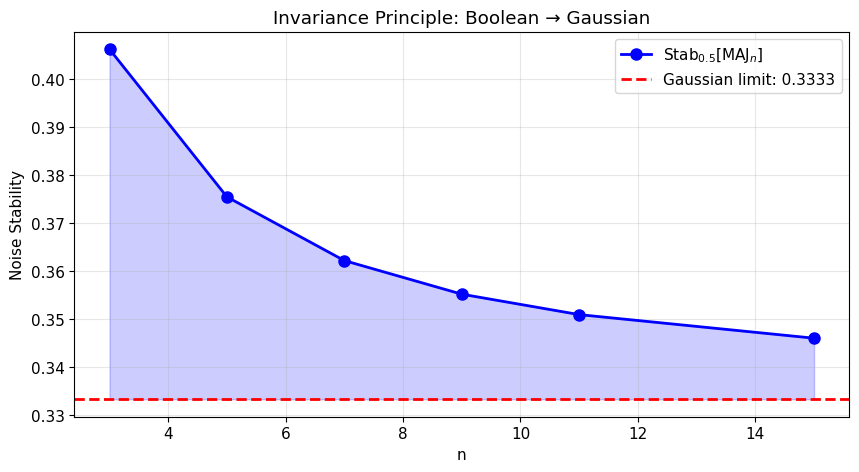


2. GaussianAnalyzer Results

Function        | max Inf    | Berry-Esseen | Approx Gaussian?
------------------------------------------------------------
Majority_9      | 0.2734     | 0.0238       | True
Majority_15     | 0.2095     | 0.0124       | True
Dictator_9      | 1.0000     | 0.5000       | False
Parity_5        | 1.0000     | 0.2236       | False

Lower Berry-Esseen bound → better Gaussian approximation

3. Multilinear Extension f̃(G) Distribution


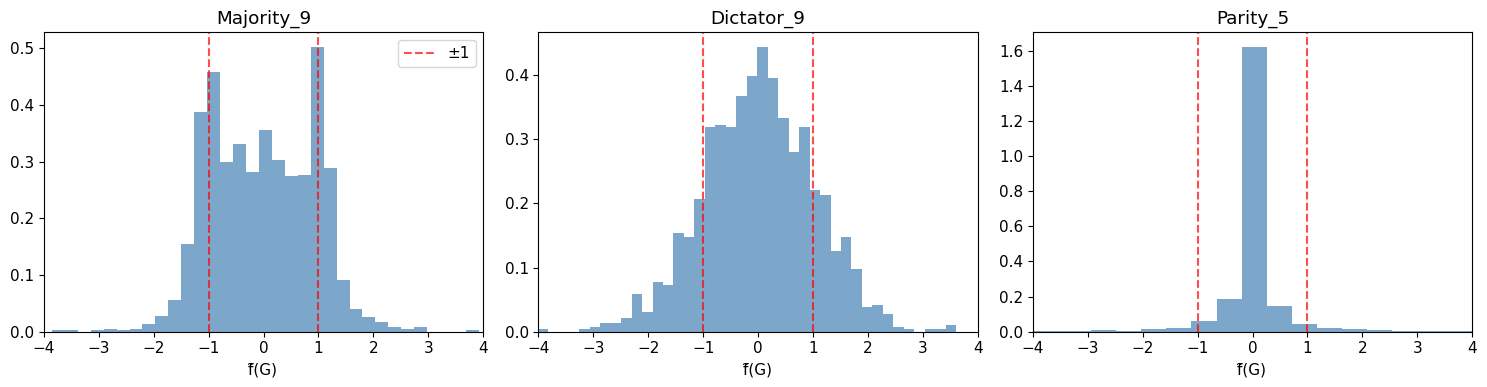

Low-influence functions: f̃(G) concentrates near ±1 (Boolean values)
High-influence functions: f̃(G) spreads out


In [9]:
# Part VI: The Invariance Principle
#
# Theorem (MOO 2010): For LOW-INFLUENCE multilinear polynomials,
#   the distribution under Boolean inputs ≈ distribution under Gaussian inputs

from boofun.analysis.gaussian import GaussianAnalyzer
from boofun.analysis.invariance import InvarianceAnalyzer

# ============================================================
# PART 1: Noise Stability Convergence
# ============================================================
print("1. Invariance: Boolean Noise Stability → Gaussian Limit")
print("=" * 65)

rho = 0.5
ns = [3, 5, 7, 9, 11, 15]
gaussian_limit = (2/np.pi) * np.arcsin(rho)

print(f"Sheppard's formula: (2/π)·arcsin({rho}) = {gaussian_limit:.4f}")
print()
print(f"{'n':<5} | {'Stab_ρ[MAJ_n]':<15} | {'Diff from Gaussian'}")
print("-" * 45)

boolean_stab = []
for n in ns:
    maj = bf.majority(n)
    analyzer = SpectralAnalyzer(maj)
    stab = analyzer.noise_stability(rho)
    boolean_stab.append(stab)
    print(f"{n:<5} | {stab:<15.4f} | {abs(stab - gaussian_limit):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(ns, boolean_stab, 'bo-', label=r'$\text{Stab}_{0.5}[\text{MAJ}_n]$', linewidth=2, markersize=8)
plt.axhline(y=gaussian_limit, color='r', linestyle='--', label=f'Gaussian limit: {gaussian_limit:.4f}', linewidth=2)
plt.fill_between(ns, boolean_stab, gaussian_limit, alpha=0.2, color='blue')
plt.xlabel('n')
plt.ylabel('Noise Stability')
plt.title('Invariance Principle: Boolean → Gaussian')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================
# PART 2: Library Analyzers
# ============================================================
print("\n" + "=" * 65)
print("2. GaussianAnalyzer Results")
print("=" * 65)
print()

functions = [
    ("Majority_9", bf.majority(9)),
    ("Majority_15", bf.majority(15)),
    ("Dictator_9", bf.dictator(9, 0)),
    ("Parity_5", bf.parity(5)),
]

print(f"{'Function':<15} | {'max Inf':<10} | {'Berry-Esseen':<12} | {'Approx Gaussian?'}")
print("-" * 60)

for name, f in functions:
    spec = SpectralAnalyzer(f)
    gauss = GaussianAnalyzer(f)
    
    max_inf = max(spec.influences())
    be = gauss.berry_esseen()
    is_gaussian = gauss.is_approximately_gaussian()
    
    print(f"{name:<15} | {max_inf:<10.4f} | {be:<12.4f} | {is_gaussian}")

print()
print("Lower Berry-Esseen bound → better Gaussian approximation")

# ============================================================
# PART 3: Multilinear Extension Distribution
# ============================================================
print("\n" + "=" * 65)
print("3. Multilinear Extension f̃(G) Distribution")
print("=" * 65)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, f) in zip(axes, [
    ("Majority_9", bf.majority(9)),
    ("Dictator_9", bf.dictator(9, 0)),
    ("Parity_5", bf.parity(5)),
]):
    gauss = GaussianAnalyzer(f)
    mle = gauss.multilinear_extension()
    n = f.n_vars
    
    # Sample f̃(G) - reduced to 1500 samples
    samples = [mle(np.random.randn(n)) for _ in range(1500)]
    
    ax.hist(samples, bins=40, density=True, alpha=0.7, color='steelblue')
    ax.axvline(x=-1, color='red', linestyle='--', alpha=0.7)
    ax.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='±1')
    ax.set_title(name)
    ax.set_xlabel('f̃(G)')
    ax.set_xlim(-4, 4)
    if ax == axes[0]:
        ax.legend()

plt.tight_layout()
plt.show()

print("Low-influence functions: f̃(G) concentrates near ±1 (Boolean values)")
print("High-influence functions: f̃(G) spreads out")


## Part VII: Interactive Explorer

Explore how different functions behave under p-biased measures!

In [10]:
# Comprehensive analysis using GlobalHypercontractivityAnalyzer
from boofun.analysis.global_hypercontractivity import GlobalHypercontractivityAnalyzer

def analyze(f, name: str):
    """Analyze a function under p-biased measures."""
    print(f"\n{name}")
    print("-" * 40)
    
    n = f.n_vars
    print(f"n = {n}, degree = {f.degree()}")
    print(f"balanced = {f.is_balanced()}, monotone = {f.is_monotone()}")
    
    analyzer = GlobalHypercontractivityAnalyzer(f, p=0.5)
    
    is_global, details = analyzer.is_global(alpha=4.0)
    print(f"max I_S = {details['max_generalized_influence']:.4f} (worst S = {details['worst_set']})")
    print(f"4-global: {is_global}")
    
    hc = analyzer.hypercontractive_bound()
    print(f"α = {hc['alpha']:.4f}, bound α^(1/4) = {hc['bound']:.4f}")

analyze(bf.majority(9), "Majority_9")
analyze(bf.majority(15), "Majority_15")
analyze(bf.dictator(9, 0), "Dictator_9")
analyze(bf.tribes(3, 9), "Tribes(3,9)")
analyze(bf.parity(7), "Parity_7")



Majority_9
----------------------------------------
n = 9, degree = 9
balanced = True, monotone = True


max I_S = 6.8750 (worst S = {0, 1, 2})
4-global: False


α = 6.8750, bound α^(1/4) = 1.6193

Majority_15
----------------------------------------
n = 15, degree = 15
balanced = True, monotone = True


max I_S = 5.1562 (worst S = {0, 1, 2})
4-global: False


α = 5.1562, bound α^(1/4) = 1.5069

Dictator_9
----------------------------------------
n = 9, degree = 1
balanced = True, monotone = True


max I_S = 4.0000 (worst S = {0})
4-global: True


α = 4.0000, bound α^(1/4) = 1.4142

Tribes(3,9)
----------------------------------------
n = 9, degree = 9
balanced = False, monotone = True


max I_S = 3.0625 (worst S = {0, 1, 2})
4-global: True


α = 3.0625, bound α^(1/4) = 1.3229

Parity_7
----------------------------------------
n = 7, degree = 7
balanced = True, monotone = False
max I_S = 64.0000 (worst S = {0, 1, 2})
4-global: False
α = 64.0000, bound α^(1/4) = 2.8284


## Summary

### The Problem
Standard hypercontractivity fails for p-biased measures with small p because the 4th moment of characters diverges.

### The Solution: Global Hypercontractivity
**Theorem (KLLM)**: For functions with small *generalized* influences:
$$\|T_{1/5}f\|_4 \leq \alpha^{1/4} \|f\|_2$$

### What Makes a Function Global?
- No small set of coordinates has disproportionate influence
- Majority, Tribes are global; Dictator is the boundary case

### Applications
- **Sharp Thresholds**: Global monotone functions have sharp phase transitions
- **KKL Extension**: Influential variable theorems extend to p-biased measures
- **Invariance**: Distribution under Boolean inputs approximates Gaussian

### Key Formula
Generalized S-influence:
$$I_S(f) = \sigma^{-2|S|} \sum_{T \supseteq S} \hat{f}(T)^2$$

A function is α-global if $I_S(f) \leq \alpha$ for all S.

### Reference

Keevash, Lifshitz, Long & Minzer. [Global hypercontractivity and its applications](https://arxiv.org/abs/1906.05039). *arXiv:1906.05039*, 2019.


In [11]:
# Notebook complete.
# Topics covered:
#   1. p-Biased Fourier analysis
#   2. Generalized influences and global functions
#   3. The Global Hypercontractivity Theorem
#   4. Sharp threshold phenomena
#   5. KKL theorem for p-biased measures
#   6. The Invariance Principle
